# Supervised Group - Final Project

## Washington Data - Electric Car Sales Data Analysis and Modelling

In [6]:
!pip install uszipcode
import requests
import pandas as pd
import matplotlib.pyplot as plt
from uszipcode import SearchEngine
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score, classification_report, confusion_matrix
import statsmodels.api as sm
import numpy as np

  Obtaining dependency information for uszipcode from https://files.pythonhosted.org/packages/b6/ba/a3e285c39363fe94c961cf483bd37064d19c454611d73c31dedd54e3373e/uszipcode-1.0.1-py2.py3-none-any.whl.metadata
  Obtaining dependency information for pathlib-mate from https://files.pythonhosted.org/packages/5e/0f/6b6342767cb06562f4d67295191cd5c63775c04765766499a70265388db6/pathlib_mate-1.3.2-py3-none-any.whl.metadata
  Obtaining dependency information for fuzzywuzzy from https://files.pythonhosted.org/packages/43/ff/74f23998ad2f93b945c0309f825be92e04e0348e062026998b5eefef4c33/fuzzywuzzy-0.18.0-py2.py3-none-any.whl.metadata
  Obtaining dependency information for haversine>=2.5.0 from https://files.pythonhosted.org/packages/5b/f1/b7274966f0b5b665d9114e86d09c6bc87d241781d63d8817323dcfa940c6/haversine-2.8.1-py2.py3-none-any.whl.metadata
  Obtaining dependency information for sqlalchemy-mate>=1.4.28.3 from https://files.pythonhosted.org/packages/8c/db/92f294181a7498696ae8de3cdc2ae06e75c1b19c62a4

/Users/jay/anaconda3/lib/python3.11/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


### Functions used to perform modelling

In [7]:
def fetchAndParseCarData(url):
    try:
        response = requests.get(url)
        response.raise_for_status()
        json_data = response.json()
        
        df = pd.DataFrame(json_data)
        if df is not None:
            return df

    except requests.exceptions.RequestException as e:
        print(f"Failed to fetch data from {url}: {e}")
        return None

In [8]:
def removeColumnandAddGenericID(df, columnTobeRemoved):
    if columnTobeRemoved in df.columns:
        df = df.drop(columnTobeRemoved, axis=1)
        df['ID'] = range(1, len(df) + 1)
        df.set_index('ID', inplace=True)
    else:
        print(f"Column '{columnTobeRemoved}' not found in DataFrame. Returning the original DataFrame.")
    return df

In [9]:
def plotTop5(column, car_df):

  top_5 = car_df[column].value_counts().nlargest(5)

  plt.figure(figsize=(8, 4))
  plt.plot(top_5.index, top_5.values, marker='o')
  plt.xlabel(column)
  plt.ylabel('Count')
  plt.title(f'Count of {column}')
  plt.grid(True)
  plt.tight_layout()
  plt.show()


In [10]:
def plotTopN(car_df, columns, n=5, figsize=(10, 6), layout=(2, 2)):

  fig, axes = plt.subplots(layout[0], layout[1], figsize=figsize)

  for i, col in enumerate(columns):
    top_n = car_df[col].value_counts().nlargest(n)

    if len(top_n) < n:  
      top_n = top_n.append(pd.Series(0, index=[f'Other_{j}' for j in range(n - len(top_n))]))

    axes[i // layout[1], i % layout[1]].plot(top_n.index, top_n.values, marker='o')
    axes[i // layout[1], i % layout[1]].set_xlabel(col)
    axes[i // layout[1], i % layout[1]].set_ylabel('Count')
    axes[i // layout[1], i % layout[1]].set_title(f'Top {n} in {col}s')
    axes[i // layout[1], i % layout[1]].grid(True)

  fig.suptitle(f'Top {n} for Columns', fontsize=12)
  plt.tight_layout()
  plt.show()


### Data Retrieval and pre-processing

Using url from washington real data - the limit parameter here specifies the number of data we want to work with.

In [11]:
url = 'https://data.wa.gov/resource/f6w7-q2d2.json?$limit=5000&$where=electric_range <> "0" AND base_msrp <> "0"'
carDF = fetchAndParseCarData(url)
print(f'Shape:{carDF.shape}')
carDF.head()

Shape:(3344, 17)


,vin_1_10,county,city,state,zip_code,model_year,make,model,ev_type,cafv_type,electric_range,base_msrp,legislative_district,dol_vehicle_id,geocoded_column,electric_utility,_2020_census_tract
0,KNDJX3AE9H,Thurston,Olympia,WA,98502,2017,KIA,SOUL EV,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,93,32250,22,140569600,"{'type': 'Point', 'coordinates': [-122.92145, ...",PUGET SOUND ENERGY INC,53067012002
1,KNDJX3AE5G,Snohomish,Edmonds,WA,98020,2016,KIA,SOUL,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,93,31950,32,158961099,"{'type': 'Point', 'coordinates': [-122.37507, ...",PUGET SOUND ENERGY INC,53061050700
2,5YJSA1DN6D,Yakima,Yakima,WA,98903,2013,TESLA,MODEL S,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,208,69900,14,156737612,"{'type': 'Point', 'coordinates': [-120.477805,...",PACIFICORP,53077003003
3,5YJSA1CG6D,Kitsap,Port Orchard,WA,98367,2013,TESLA,MODEL S,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,208,69900,26,124244284,"{'type': 'Point', 'coordinates': [-122.6847073...",PUGET SOUND ENERGY INC,53035092902
4,WBA8E1C52H,King,Tukwila,WA,98168,2017,BMW,330E,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,14,44100,11,139331412,"{'type': 'Point', 'coordinates': [-122.286465,...",CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA),53033027300


In [12]:
carDF.columns

Index(['vin_1_10', 'county', 'city', 'state', 'zip_code', 'model_year', 'make',
       'model', 'ev_type', 'cafv_type', 'electric_range', 'base_msrp',
       'legislative_district', 'dol_vehicle_id', 'geocoded_column',
       'electric_utility', '_2020_census_tract'],
      dtype='object')

In [14]:
carDF = carDF[['vin_1_10', 'county', 'city', 'state','zip_code','model_year','make','model','ev_type','electric_range','base_msrp']]
carDF.columns

Index(['vin_1_10', 'county', 'city', 'state', 'zip_code', 'model_year', 'make',
       'model', 'ev_type', 'electric_range', 'base_msrp'],
      dtype='object')

In [15]:
carDF = carDF.rename(columns={'vin_1_10': 'vin_id'})
carDF.head()

,vin_id,county,city,state,zip_code,model_year,make,model,ev_type,electric_range,base_msrp
0,KNDJX3AE9H,Thurston,Olympia,WA,98502,2017,KIA,SOUL EV,Battery Electric Vehicle (BEV),93,32250
1,KNDJX3AE5G,Snohomish,Edmonds,WA,98020,2016,KIA,SOUL,Battery Electric Vehicle (BEV),93,31950
2,5YJSA1DN6D,Yakima,Yakima,WA,98903,2013,TESLA,MODEL S,Battery Electric Vehicle (BEV),208,69900
3,5YJSA1CG6D,Kitsap,Port Orchard,WA,98367,2013,TESLA,MODEL S,Battery Electric Vehicle (BEV),208,69900
4,WBA8E1C52H,King,Tukwila,WA,98168,2017,BMW,330E,Plug-in Hybrid Electric Vehicle (PHEV),14,44100


### Data Cleaning and Processing

Removing "vin_id" column and adding a "id" column to preserve privacy

In [16]:
carDF = removeColumnandAddGenericID(carDF, 'vin_id')
carDF.head()

,county,city,state,zip_code,model_year,make,model,ev_type,electric_range,base_msrp
ID,,,,,,,,,,
1,Thurston,Olympia,WA,98502,2017,KIA,SOUL EV,Battery Electric Vehicle (BEV),93,32250
2,Snohomish,Edmonds,WA,98020,2016,KIA,SOUL,Battery Electric Vehicle (BEV),93,31950
3,Yakima,Yakima,WA,98903,2013,TESLA,MODEL S,Battery Electric Vehicle (BEV),208,69900
4,Kitsap,Port Orchard,WA,98367,2013,TESLA,MODEL S,Battery Electric Vehicle (BEV),208,69900
5,King,Tukwila,WA,98168,2017,BMW,330E,Plug-in Hybrid Electric Vehicle (PHEV),14,44100


Processing Mathematical columns

In [17]:
carDF['electric_range'] = pd.to_numeric(carDF['electric_range'], errors='coerce').astype('Int64')
carDF['electric_range'] = carDF['electric_range'].fillna(0).astype(int)
carDF['base_msrp'] = pd.to_numeric(carDF['base_msrp'], errors='coerce').astype('float')
carDF['base_msrp'] = carDF['base_msrp'].fillna(0).astype(float)


mean = carDF['electric_range'].mean()
std_dev = carDF['electric_range'].std()
max = carDF['electric_range'].max()
min = carDF['electric_range'].min()
range_of_values = max - min 


print("Electric range")
print(f"Mean: {mean}")
print(f"Standard Deviation: {std_dev}")
print(f"Max: {max}")
print(f"Min: {min}")
print(f"Range of Electric Vehicle Range: {range_of_values}")

mean = carDF['base_msrp'].mean()
std_dev = carDF['base_msrp'].std()
max = carDF['base_msrp'].max()
min = carDF['base_msrp'].min()
range_of_values = max - min 
print("\n")
print("MSRP")
print(f"Mean: {mean}")
print(f"Standard Deviation: {std_dev}")
print(f"Max: {max}")
print(f"Min: {min}")
print(f"Range of MSRP: {range_of_values}")

Electric range
Mean: 121.79605263157895
Standard Deviation: 89.9905650452118
Max: 265
Min: 12
Range of Electric Vehicle Range: 253


MSRP
Mean: 57078.250598086124
Standard Deviation: 22795.51813172544
Max: 845000.0
Min: 31950.0
Range of MSRP: 813050.0


Checking if there is normalization in the range of the electric range; Removing 0 values as it is the mode and can be misleading

In [19]:
non_zero_electric_range = carDF.loc[carDF['electric_range'] != 0, 'electric_range']
non_zero_electric_range_series = pd.Series(non_zero_electric_range)
len(non_zero_electric_range_series)

3344

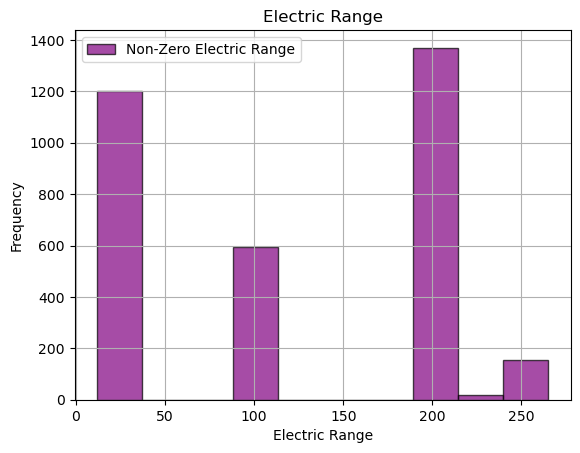

In [20]:
fig, ax = plt.subplots()
non_zero_electric_range_series.hist(ax=ax, bins=10, color='purple', edgecolor='black', alpha=0.7, label='Non-Zero Electric Range')

ax.set_xlabel('Electric Range')
ax.set_ylabel('Frequency')
ax.set_title('Electric Range')
ax.legend()

plt.show()

Checking for missing values

In [21]:
carDF.isnull().sum()

county            1
city              1
state             0
zip_code          1
model_year        0
make              0
model             0
ev_type           0
electric_range    0
base_msrp         0
dtype: int64

### Visualizing Data as is

first looking at top 5

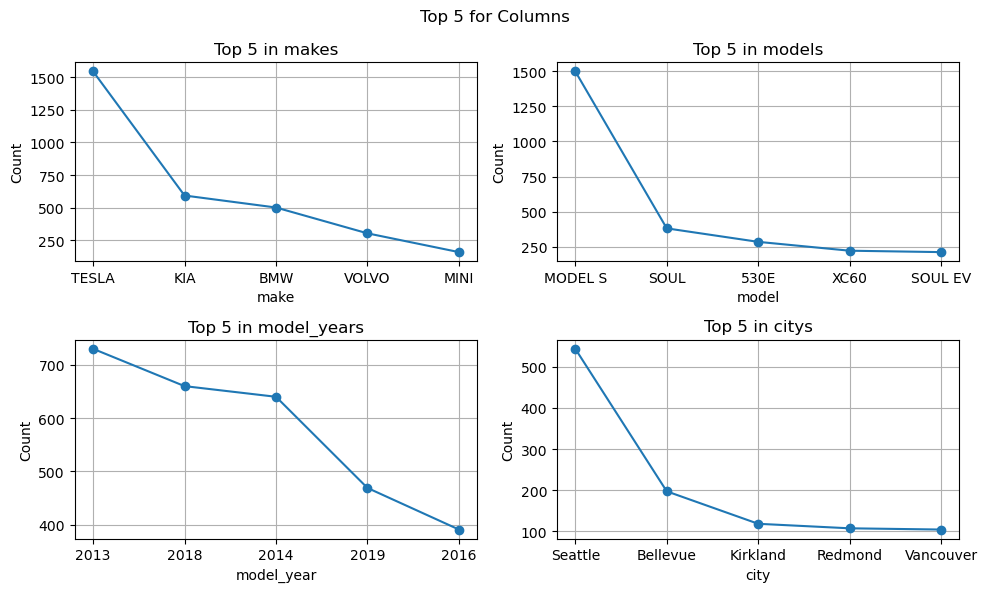

In [22]:
columns_to_plot = ['make', 'model', 'model_year', 'city'] 
plotTopN(carDF, columns_to_plot, n=5)

Since we see a monopoly in a Manufacturer, let's see their specific data. 

Download /Users/jay/.uszipcode/simple_db.sqlite from https://github.com/MacHu-GWU/uszipcode-project/releases/download/1.0.1.db/simple_db.sqlite ...
  1.00 MB downloaded ...
  2.00 MB downloaded ...
  3.00 MB downloaded ...
  4.00 MB downloaded ...
  5.00 MB downloaded ...
  6.00 MB downloaded ...
  7.00 MB downloaded ...
  8.00 MB downloaded ...
  9.00 MB downloaded ...
  10.00 MB downloaded ...
  11.00 MB downloaded ...
  Complete!


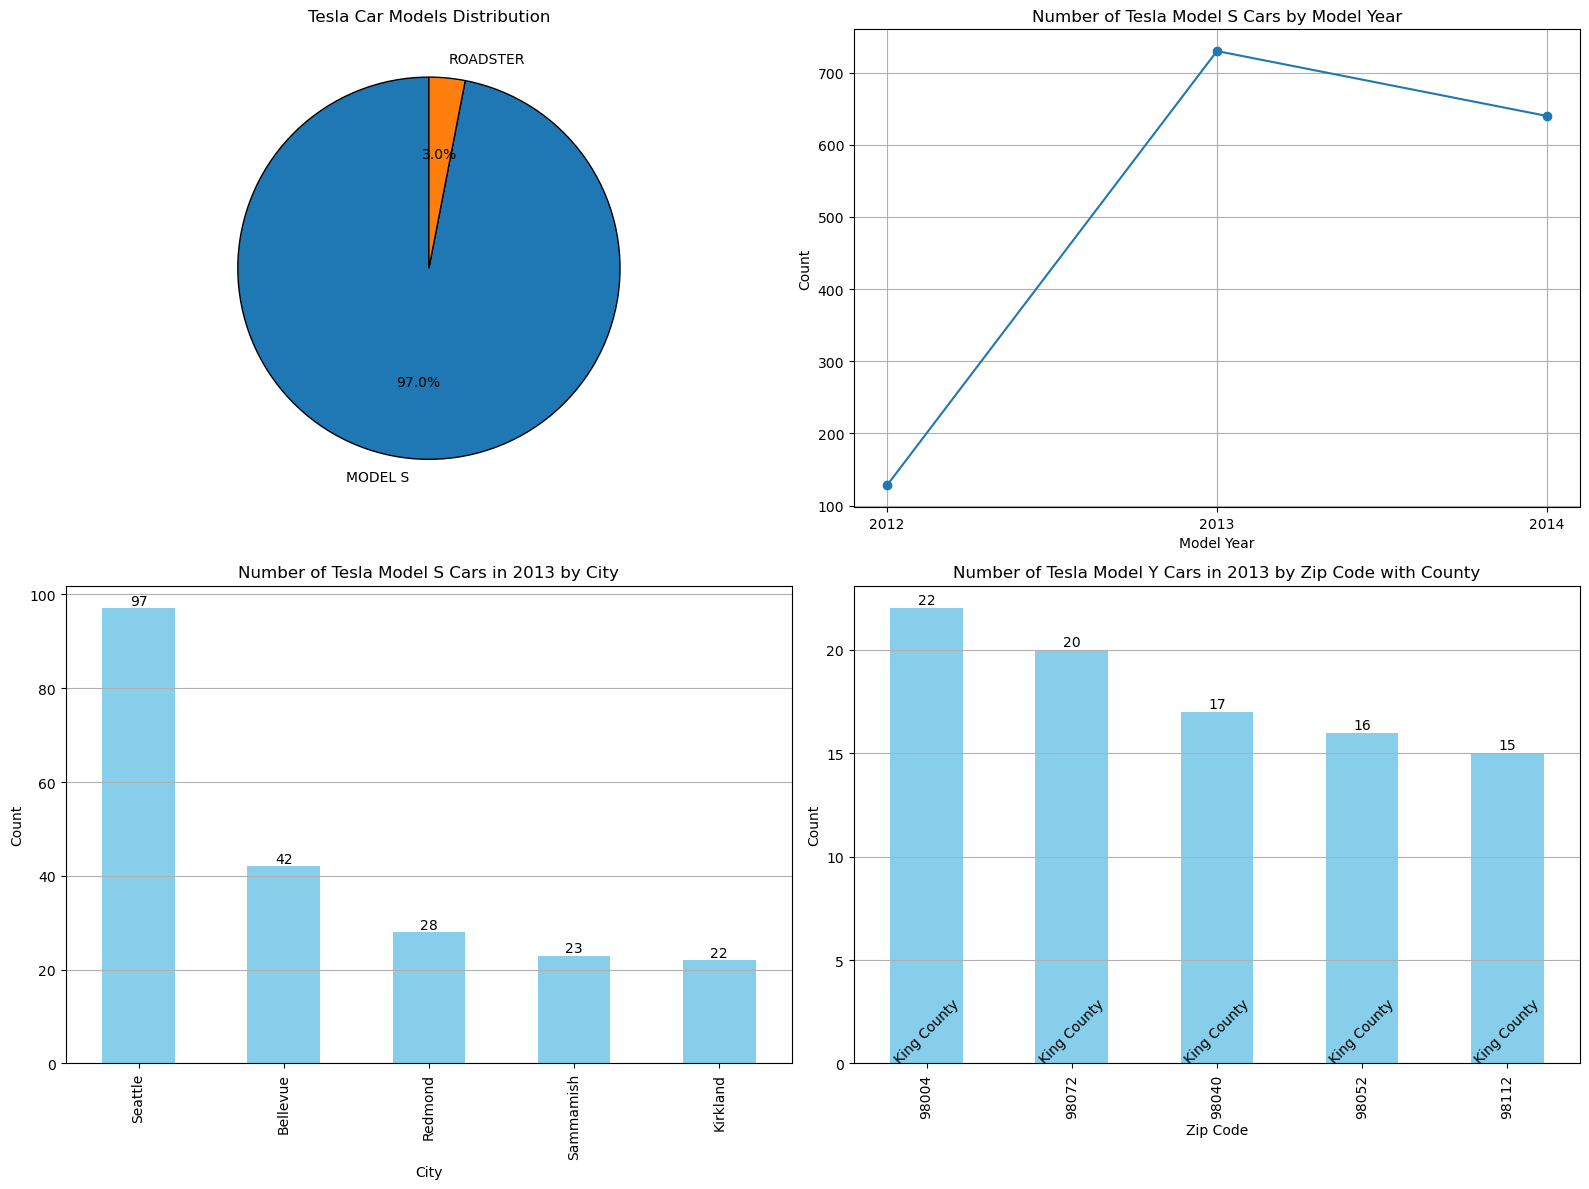

In [23]:
teslaCarDF = carDF[carDF['make'] == 'TESLA']
tesla_model_3 = teslaCarDF[teslaCarDF['model'] == 'MODEL S']


# Filter DataFrame for Tesla Model Y cars in 2023
tesla_model_3_2023 = tesla_model_3[tesla_model_3['model_year'] == '2013']

# Assuming 'city' is a column in tesla_model_y_2023
city_counts_2023 = tesla_model_3_2023['city'].value_counts().nlargest(5)

# Assuming 'zip_code' is a column in tesla_model_y_2023
zip_counts_2023 = tesla_model_3_2023['zip_code'].value_counts().nlargest(5)

# Create subplots for all graphs
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# Plot pie chart for car models distribution
pie = teslaCarDF['model'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, ax=axs[0, 0])
[p.set_edgecolor('black') for p in pie.patches]
axs[0, 0].set_title('Tesla Car Models Distribution')
axs[0, 0].set_ylabel('')

# Plot line chart for number of Tesla Model Y cars by model year
model_year_counts = tesla_model_3['model_year'].value_counts().sort_index()
axs[0, 1].plot(model_year_counts.index, model_year_counts.values, marker='o')
axs[0, 1].set_title('Number of Tesla Model S Cars by Model Year')
axs[0, 1].set_xlabel('Model Year')
axs[0, 1].set_ylabel('Count')
axs[0, 1].grid(True)

# Plot bar chart for number of Tesla Model Y cars in 2023 by city
bars_city = city_counts_2023.plot(kind='bar', color='skyblue', ax=axs[1, 0])
bars_city.set_xlabel('City')
bars_city.set_ylabel('Count')
bars_city.set_title('Number of Tesla Model S Cars in 2013 by City')
bars_city.grid(axis='y')
for bar in bars_city.patches:
    yval = bar.get_height()
    axs[1, 0].text(bar.get_x() + bar.get_width()/2, yval + 0.05, yval, ha='center', va='bottom')

# Plot bar chart for number of Tesla Model Y cars in 2023 by zip code with county
search = SearchEngine()
counties = []
for zip_code in zip_counts_2023.index:
    result = search.by_zipcode(zip_code)
    counties.append(result.county)

bars_zip = zip_counts_2023.plot(kind='bar', color='skyblue', ax=axs[1, 1])
bars_zip.set_xlabel('Zip Code')
bars_zip.set_ylabel('Count')
bars_zip.set_title('Number of Tesla Model Y Cars in 2013 by Zip Code with County')
bars_zip.grid(axis='y')
for i, bar in enumerate(bars_zip.patches):
    yval = bar.get_height()
    axs[1, 1].text(bar.get_x() + bar.get_width()/2, yval + 0.05, yval, ha='center', va='bottom')
    axs[1, 1].text(bar.get_x() + bar.get_width()/2, -0.1, counties[i], ha='center', va='bottom', rotation=45)

plt.tight_layout()
plt.show()

### Regression Analysis on the Dataset

Creating a derived Target column based on Electric Range to determine the range

In [24]:
carDF['high_range'] = (carDF['electric_range'] > 150).astype(int)
carDF

,county,city,state,zip_code,model_year,make,model,ev_type,electric_range,base_msrp,high_range
ID,,,,,,,,,,,
1,Thurston,Olympia,WA,98502,2017,KIA,SOUL EV,Battery Electric Vehicle (BEV),93,32250.0,0
2,Snohomish,Edmonds,WA,98020,2016,KIA,SOUL,Battery Electric Vehicle (BEV),93,31950.0,0
3,Yakima,Yakima,WA,98903,2013,TESLA,MODEL S,Battery Electric Vehicle (BEV),208,69900.0,1
4,Kitsap,Port Orchard,WA,98367,2013,TESLA,MODEL S,Battery Electric Vehicle (BEV),208,69900.0,1
5,King,Tukwila,WA,98168,2017,BMW,330E,Plug-in Hybrid Electric Vehicle (PHEV),14,44100.0,0
...,...,...,...,...,...,...,...,...,...,...,...
3340,King,Vashon,WA,98070,2016,KIA,SOUL,Battery Electric Vehicle (BEV),93,31950.0,0
3341,Whatcom,Bellingham,WA,98225,2017,KIA,SOUL EV,Battery Electric Vehicle (BEV),93,32250.0,0
3342,Pierce,Gig Harbor,WA,98335,2013,TESLA,MODEL S,Battery Electric Vehicle (BEV),208,69900.0,1


Creating a Label Encoder for Make, as it only has 10 unique values

In [25]:
label_encoder = LabelEncoder()

# Fit and transform the 'make' column
carDF['make_encoded'] = label_encoder.fit_transform(carDF['make'])
carDF.head()

,county,city,state,zip_code,model_year,make,model,ev_type,electric_range,base_msrp,high_range,make_encoded
ID,,,,,,,,,,,,
1,Thurston,Olympia,WA,98502,2017,KIA,SOUL EV,Battery Electric Vehicle (BEV),93,32250.0,0,4
2,Snohomish,Edmonds,WA,98020,2016,KIA,SOUL,Battery Electric Vehicle (BEV),93,31950.0,0,4
3,Yakima,Yakima,WA,98903,2013,TESLA,MODEL S,Battery Electric Vehicle (BEV),208,69900.0,1,8
4,Kitsap,Port Orchard,WA,98367,2013,TESLA,MODEL S,Battery Electric Vehicle (BEV),208,69900.0,1,8
5,King,Tukwila,WA,98168,2017,BMW,330E,Plug-in Hybrid Electric Vehicle (PHEV),14,44100.0,0,0


Linear Regression

In [26]:
X = carDF[['base_msrp', 'electric_range', 'model_year']]
y = carDF['high_range']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Train the model on the training set
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the regression coefficients
coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
print("Regression Coefficients:")
print(coefficients)

print("\nMean Squared Error:", mse)
print("R-squared:", r2)


Regression Coefficients:
                Coefficient
base_msrp          0.000004
electric_range     0.005031
model_year         0.005862

Mean Squared Error: 0.017296168615255052
R-squared: 0.929733765507115


Logistic regression

In [27]:
X = carDF[['base_msrp', 'electric_range', 'model_year', 'make_encoded']]
X = pd.get_dummies(X)  
y = carDF['high_range']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

# Create a logistic regression model
model = LogisticRegression(max_iter=1000)

# Train the model on the training set
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       344
           1       1.00      1.00      1.00       325

    accuracy                           1.00       669
   macro avg       1.00      1.00      1.00       669
weighted avg       1.00      1.00      1.00       669


Confusion Matrix:
[[344   0]
 [  0 325]]


- The combination of base_msrp, electric_range, and model_year seems to have strong predictive power for determining the high_range target variable. The model was able to use these features to make perfect predictions on the test set.
- : Each of these features (base_msrp, electric_range, model_year) appears to be highly relevant for predicting high_range. It suggests that these features are crucial in determining whether a car has a high range or no
- ip: The perfect accuracy suggests that there may be a clear linear relationship between these features and the target variable. This could imply that as base_msrp or electric_range increases, the likelihood of high_range being 1 also increa
- ting: While achieving perfect accuracy might raise concerns about overfitting, it's also possible that the dataset is relatively small or the features are highly informative, leading to such high performance.

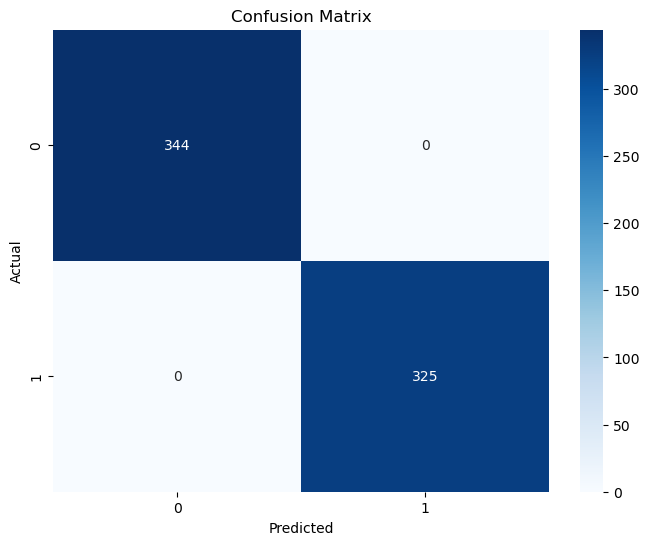

In [28]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [30]:
carDF['model_year'] = carDF['model_year'].astype(int)
print(carDF.dtypes)

county             object
city               object
state              object
zip_code           object
model_year          int64
make               object
model              object
ev_type            object
electric_range      int64
base_msrp         float64
high_range          int64
make_encoded        int64
dtype: object


In [31]:
from sklearn.feature_selection import SelectKBest, f_regression

# Select the top 3 features
selector = SelectKBest(score_func=f_regression, k=3)
X_selected = selector.fit_transform(X_train, y_train)

# Get the selected feature indices
selected_indices = selector.get_support(indices=True)

# Get the names of the selected features
selected_features = X.columns[selected_indices]

print("Selected Features:", selected_features)


Selected Features: Index(['electric_range', 'make_encoded', 'model_year_2013'], dtype='object')


In [32]:
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.model_selection import train_test_split

# Assuming carDF is your DataFrame with 'base_msrp' and 'high_range' columns
X = carDF[['base_msrp']]  # Selecting 'base_msrp' as the feature
y = carDF['high_range']   # Selecting 'high_range' as the target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shape of X_train (number of samples, number of features)
print("Shape of X_train:", X_train.shape)
# Assuming X_train, X_test, y_train, y_test are already defined
# Train the linear regression model

X_train_np = X_train.values 
y_train_np = y_train.values

# Now you can fit your model using X_train_np and y_train_np
# model.fit(X_train_np, y_train_np)
model = LinearRegression()
model.fit(X_train_np, y_train_np)

# Predict high_range for the test set
y_pred = model.predict(X_test)

# Find the optimal price where high_range is closest to 1
prices = np.arange(0, 100000, 1000)  # Adjust the range as needed
optimal_price = None
min_diff = float('inf')

for price in prices:
    pred_high_range = model.predict([[price]])[0]
    diff = abs(pred_high_range - 1)
    if diff < min_diff:
        min_diff = diff
        optimal_price = price

print("Optimal Price for High Range =", optimal_price)


Shape of X_train: (2675, 1)
Optimal Price for High Range = 99000


/Users/jay/anaconda3/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


## Clustering

### Hierarchical Clustering

In [33]:
# Hierarchical Clustering
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

In [35]:
# Select relevant features for clustering
cluster_cols = ['electric_range', 'base_msrp', 'model_year', 'make_encoded']
X = carDF[cluster_cols]

# Perform hierarchical clustering
cluster = AgglomerativeClustering(n_clusters=None, distance_threshold=0, linkage='ward')
cluster.fit_predict(X)

array([3343, 3342, 3341, ...,    1,    2,    0])

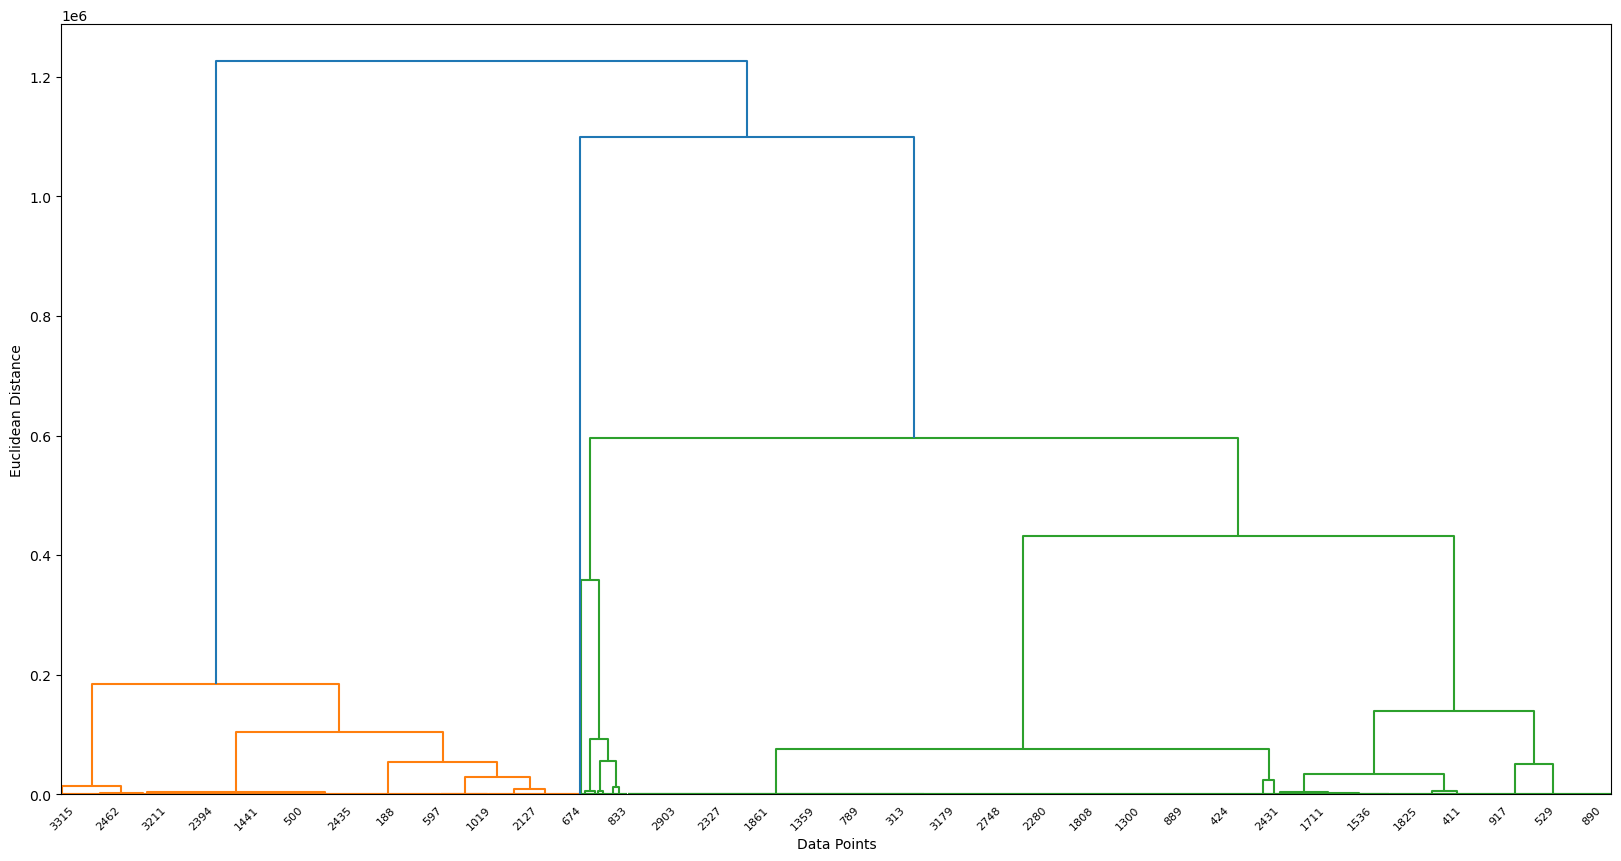

In [36]:
plt.figure(figsize=(20, 10))  # Increase figure size
dendrogram = sch.dendrogram(sch.linkage(X, method='ward'), labels=carDF.index.values)

# Sample labels
plt.gca().set_xticks(plt.gca().get_xticks()[::100])  # Display every 10th label

plt.xlabel("Data Points")
plt.ylabel("Euclidean Distance")
plt.xticks(rotation=45, fontsize=8)  # Rotate x-axis labels and decrease font size
plt.show()

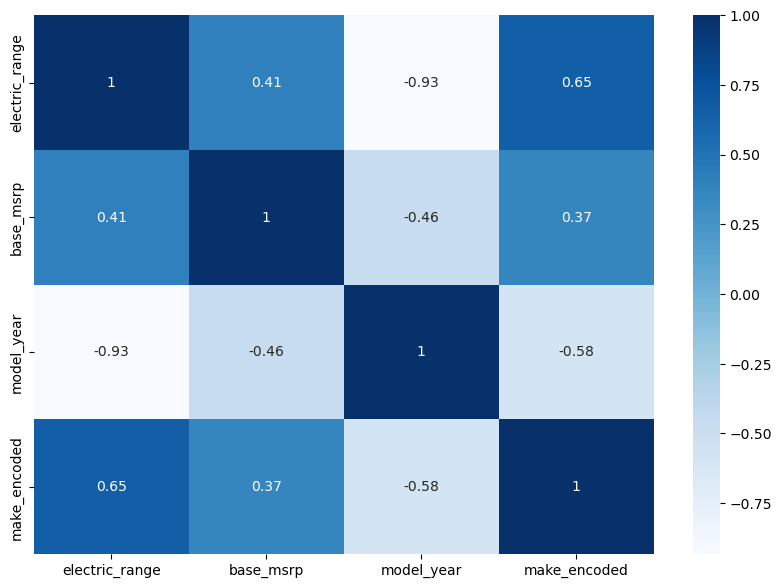

In [37]:
# Plot heat map
plt.figure(figsize=(10, 7))
sns.heatmap(X.corr(), annot=True, cmap='Blues')
plt.show()

In [38]:
# Distance matrix
from sklearn.metrics import pairwise_distances
dist_matrix = pairwise_distances(X, metric='euclidean')
print(dist_matrix)

[[    0.           300.00166666 37650.17605537 ... 37650.17605537
  20650.14055642 11850.2640055 ]
 [  300.00166666     0.         37950.1745714  ... 37950.1745714
  20950.13866303 12150.25752813]
 [37650.17605537 37950.1745714      0.         ...     0.
  17001.0740249  25800.73091988]
 ...
 [37650.17605537 37950.1745714      0.         ...     0.
  17001.0740249  25800.73091988]
 [20650.14055642 20950.13866303 17001.0740249  ... 17001.0740249
      0.          8800.00534091]
 [11850.2640055  12150.25752813 25800.73091988 ... 25800.73091988
   8800.00534091     0.        ]]


## K-NN Clustering

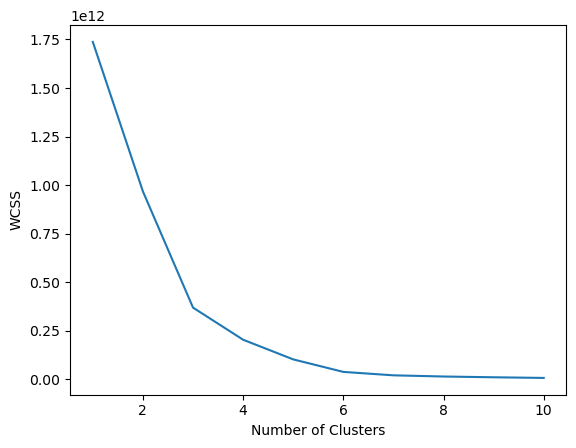

In [40]:
# K-NN Clustering
from sklearn.cluster import KMeans

# Elbow method to find optimal number of clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

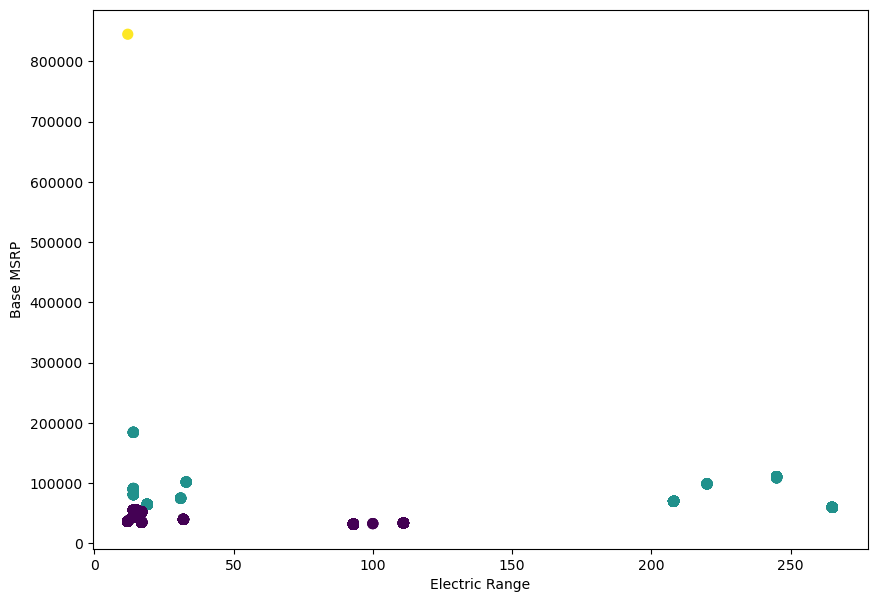

In [41]:
# Perform K-NN clustering with optimal number of clusters
n_clusters = 3  # Change this based on the elbow plot
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
y_kmeans = kmeans.fit_predict(X)

# Plot clusters
plt.figure(figsize=(10, 7))
plt.scatter(X['electric_range'], X['base_msrp'], c=y_kmeans, s=50, cmap='viridis')
plt.xlabel('Electric Range')
plt.ylabel('Base MSRP')
plt.show()

In [42]:
# Print cluster members
for i in range(n_clusters):
    print(f"Cluster {i}:")
    print(carDF[y_kmeans == i][cluster_cols])

Cluster 0:
      electric_range  base_msrp  model_year  make_encoded
ID                                                       
1                 93    32250.0        2017             4
2                 93    31950.0        2016             4
5                 14    44100.0        2017             0
6                 93    31950.0        2016             4
7                 14    45600.0        2018             0
...              ...        ...         ...           ...
3336              93    31950.0        2016             4
3340              93    31950.0        2016             4
3341              93    32250.0        2017             4
3343              17    52900.0        2019             9
3344              14    44100.0        2017             0

[1625 rows x 4 columns]
Cluster 1:
      electric_range  base_msrp  model_year  make_encoded
ID                                                       
3                208    69900.0        2013             8
4                208    6

## Text Mining


In [40]:
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

ModuleNotFoundError: No module named 'nltk'

In [71]:
import pandas as pd
from textblob import TextBlob
import matplotlib.pyplot as plt

# Load the data from a CSV file
data = pd.read_csv('data.csv') 

In [72]:
# Function to calculate sentiment score
def sentiment_score(review):
    return TextBlob(review).sentiment.polarity

# Calculate sentiment scores for each review
data['sentiment_score'] = data['review'].apply(sentiment_score)



In [73]:
def sentiment_to_rating(score):
    # Scale the polarity from -1 to 1 (negative to positive) to a scale of 0 to 1
    scaled_score = (score + 1) / 2  
    # Convert to a 1-5 scale
    return round(scaled_score * 4 + 1, 0)

# Convert sentiment scores to custom star ratings
data['custom_rating'] = data['sentiment_score'].apply(sentiment_to_rating)


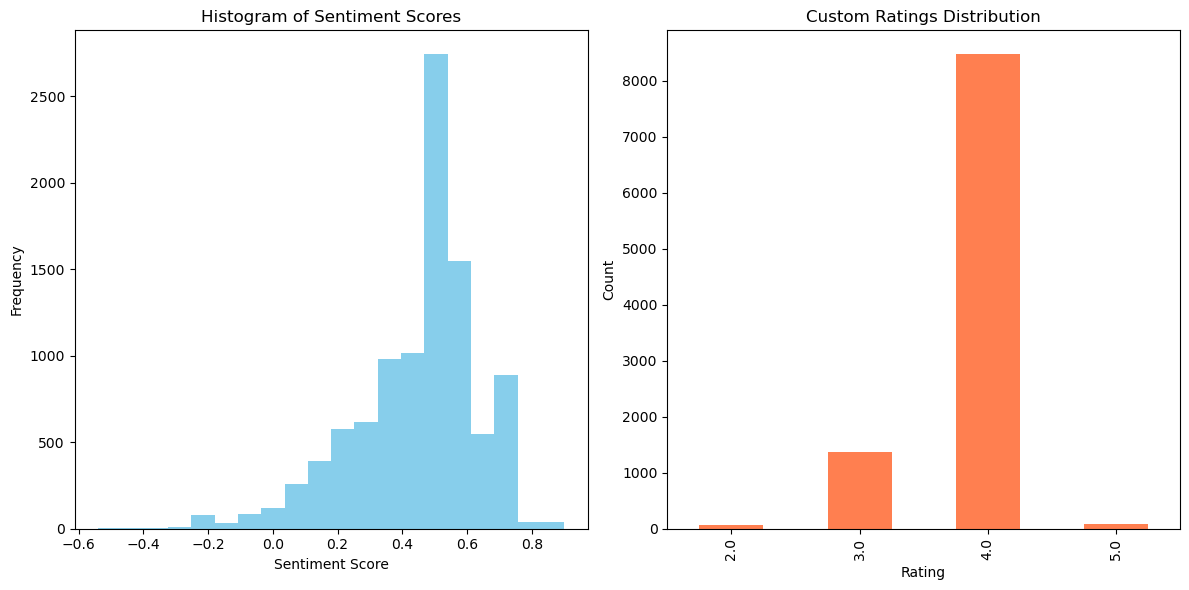

In [79]:
import matplotlib.pyplot as plt

# Plotting sentiment scores
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(data['sentiment_score'], bins=20, color='skyblue')
plt.title('Histogram of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')

# Plotting custom ratings
plt.subplot(1, 2, 2)
data['custom_rating'].value_counts().sort_index().plot(kind='bar', color='coral')
plt.title('Custom Ratings Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')

# Plotting custom rating

plt.tight_layout()
plt.show()


Text(0, 0.5, 'Count')

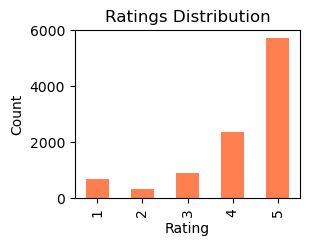

In [80]:
plt.subplot(2, 2, 1)
data['rating'].value_counts().sort_index().plot(kind='bar', color='coral')
plt.title('Ratings Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')

Correlation between custom ratings and official ratings: 0.4280361953682275


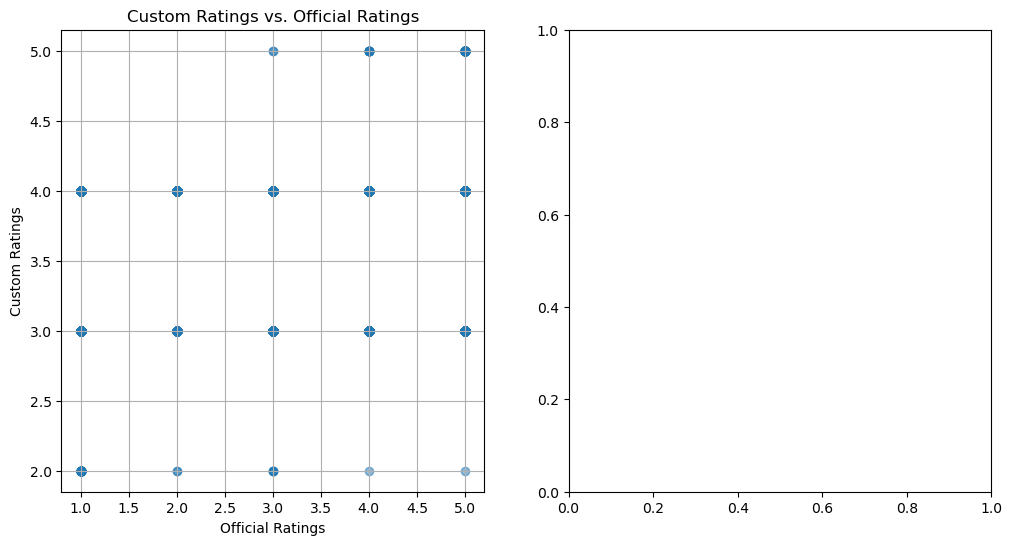

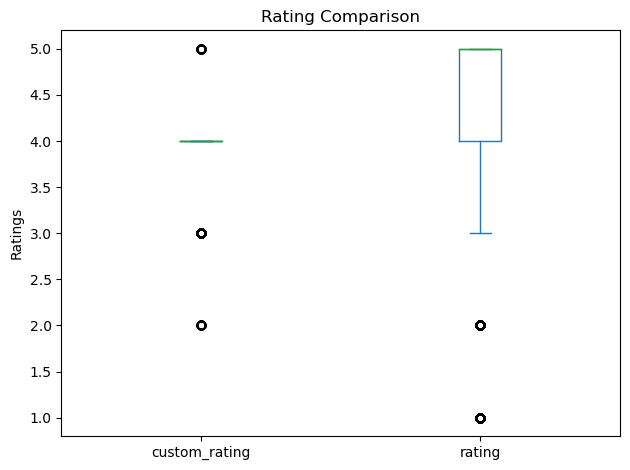

In [74]:
# Calculate correlation
correlation = data['custom_rating'].corr(data['rating'])
print("Correlation between custom ratings and official ratings:", correlation)

# Plotting the results
plt.figure(figsize=(12, 6))

# Scatter plot to show the correlation between custom ratings and official ratings
plt.subplot(1, 2, 1)
plt.scatter(data['rating'], data['custom_rating'], alpha=0.5)
plt.title('Custom Ratings vs. Official Ratings')
plt.xlabel('Official Ratings')
plt.ylabel('Custom Ratings')
plt.grid(True)

# Boxplot to compare distributions
plt.subplot(1, 2, 2)
data[['custom_rating', 'rating']].plot(kind='box', title='Rating Comparison')
plt.ylabel('Ratings')

plt.tight_layout()
plt.show()
